In [1]:
import gc
import os
import joblib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as mso
import plotly.graph_objects as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import random
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import random
import warnings
import itertools
import scipy as sp
from tqdm import tqdm
import lightgbm as lgb
from itertools import combinations
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, train_test_split



/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [2]:
#reading datasets
train_data=pd.read_feather("/kaggle/input/amexfeather/train_data.ftr")
test_data=pd.read_feather("/kaggle/input/amexfeather/test_data.ftr")
train_labels=pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv")
sample_submission=pd.read_csv("/kaggle/input/amex-default-prediction/sample_submission.csv")

In [3]:
# --- Reading Dataset ---
train_data.head().style.background_gradient(cmap='Greens').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-03-09 00:00:00,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,nan,nan,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,nan,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,nan,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,CR,O,0.007126,0.007664,nan,0.652832,0.008522,nan,0.004730,6.000000,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,nan,0.007553,0.080444,0.069092,nan,0.004326,0.007561,nan,0.007729,0.000272,0.001575,0.004238,0.001434,nan,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,nan,0.000000,0.005722,0.007084,nan,0.000198,0.008911,nan,1.000000,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,nan,0.669922,0.009972,0.004570,nan,1.008789,2.000000,nan,0.004326,nan,nan,nan,1.007812,0.210083,0.676758,0.007874,1.000000,0.238281,0.000000,4.000000,0.232178,0.236206,0.000000,0.702148,0.434326,0.003057,0.686523,0.008743,1.000000,1.002930,1.007812,1.000000,0.006805,nan,0.002052,0.005970,nan,0.004345,0.001534,nan,nan,nan,nan,nan,0.002426,0.003706,0.003819,nan,0.000569,0.000610,0.002674,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-04-07 00:00:00,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,nan,nan,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,nan,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,nan,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,CR,O,0.002413,0.007149,nan,0.646973,0.002237,nan,0.003880,6.000000,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,nan,0.004833,0.081421,0.074158,nan,0.004204,0.005302,nan,0.001864,0.000978,0.009895,0.007599,0.000509,nan,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,nan,0.000000,0.007584,0.006676,nan,0.001143,0.005905,nan,1.000000,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,nan,0.668457,0.003922,0.004654,nan,1.002930,2.000000,nan,0.008705,nan,nan,nan,1.007812,0.184082,0.822266,0.003445,1.000000,0.247192,0.000000,4.000000

In [4]:
# --- Reading Dataset ---
train_labels.head().style.background_gradient(cmap='Greens').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

customer_ID,target
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0


In [5]:
# --- Reading Dataset ---
train_labels.head().style.background_gradient(cmap='Greens').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

customer_ID,target
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0


In [6]:
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    df1 = np.concatenate(df1, axis = 0)
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    df1['customer_ID'] = customer_ids
    return df1


    # Lag Features
    for col in train_num_agg:
        if 'last' in col and col.replace('last', 'first') in train_num_agg:
            train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
            train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    
    train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
    
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)

 # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    
    # Test FE
    test = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)

   
 # Lag Features
    for col in test_num_agg:
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
            test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
            test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
 
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()

    # Save files to disk

    train.to_parquet('train_fe_plus_plus.parquet')
    test.to_parquet('test_fe_plus_plus.parquet')


In [7]:
class CFG:
    seed = 42
    n_folds = 5
    target = 'target'
    input_dir = '../input/amex-fe/'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

In [8]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

In [9]:
# Train Labels Data Exploration
print('\033[1m'"Shape of the train label data file\n"'\033[0m',train_labels.shape)

Shape of the train label data file
 (458913, 2)


In [10]:
## Data Type
print('\033[1m'"Data types of each column in train label data file\n"'\033[0m',train_labels.dtypes)

Data types of each column in train label data file
 customer_ID    object
target          int64
dtype: object


In [11]:
#Missing value in the table 

print('\033[1m'"Missing value present in each column of train label data file\n"'\033[0m',train_labels.isna().any())

Missing value present in each column of train label data file
 customer_ID    False
target         False
dtype: bool


In [12]:
# Check for the duplicated values 

print('\033[1m'"Duplicate value present in each column of train label data file\n"'\033[0m',train_labels.customer_ID.duplicated().any())

Duplicate value present in each column of train label data file
 False


In [13]:
print('\033[1m'"No of Unique customers in the  train label data file\n"'\033[0m',train_labels.customer_ID.nunique())

No of Unique customers in the  train label data file
 458913


In [14]:
# Count of the Target

print('\033[1m'"Value count of the target column in the train label data file\n"'\033[0m',train_labels.target.value_counts())

Value count of the target column in the train label data file
 0    340085
1    118828
Name: target, dtype: int64


In [15]:
target=train_labels.target.value_counts(normalize=True)
target.rename(index={1:'Default',0:'Paid'},inplace=True)
colors = ['#17becf', '#E1396C']
data = go.Pie(
values= target,
labels= target.index,
marker=dict(colors=colors),
textinfo='label+percent'
)
layout = go.Layout(
title=dict(text = "Target Distribution",x=0.46,y=0.95,font_size=20)
)
fig = go.Figure(data=data,layout=layout)
fig.show()

In [16]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

from sklearn.model_selection import train_test_split

import gc

In [17]:
class config:
    random_state = 4222
    kaggle = True

In [18]:
# Shape of the train data set

print('\033[1m'"Shape of the train  data file\n"'\033[0m',train_data.shape)

Shape of the train  data file
 (5531451, 191)


In [19]:
## Data Type
print('\033[1m'"Data types of each column in train label data file\n"'\033[0m',train_data.dtypes)

Data types of each column in train label data file
 customer_ID            object
S_2            datetime64[ns]
P_2                   float16
D_39                  float16
B_1                   float16
B_2                   float16
R_1                   float16
S_3                   float16
D_41                  float16
B_3                   float16
D_42                  float16
D_43                  float16
D_44                  float16
B_4                   float16
D_45                  float16
B_5                   float16
R_2                   float16
D_46                  float16
D_47                  float16
D_48                  float16
D_49                  float16
B_6                   float16
B_7                   float16
B_8                   float16
D_50                  float16
D_51                  float16
B_9                   float16
R_3                   float16
D_52                  float16
P_3                   float16
B_10                  float16
D_53              

In [20]:
##Missing value in the table 

print('\033[1m'"Missing value present in each column of train  data file\n"'\033[0m',train_data.isna().any())

Missing value present in each column of train  data file
 customer_ID    False
S_2            False
P_2             True
D_39           False
B_1            False
B_2             True
R_1            False
S_3             True
D_41            True
B_3             True
D_42            True
D_43            True
D_44            True
B_4            False
D_45            True
B_5            False
R_2            False
D_46            True
D_47           False
D_48            True
D_49            True
B_6             True
B_7            False
B_8             True
D_50            True
D_51           False
B_9            False
R_3            False
D_52            True
P_3             True
B_10           False
D_53            True
S_5            False
B_11           False
S_6            False
D_54            True
R_4            False
S_7             True
B_12           False
S_8            False
D_55            True
D_56            True
B_13            True
R_5            False
D_58           Fal

In [21]:
#Missing value count in the table 

print('\033[1m'"Missing value count in each column of train label data file\n"'\033[0m',train_data.isna().count())

Missing value count in each column of train label data file
 customer_ID    5531451
S_2            5531451
P_2            5531451
D_39           5531451
B_1            5531451
B_2            5531451
R_1            5531451
S_3            5531451
D_41           5531451
B_3            5531451
D_42           5531451
D_43           5531451
D_44           5531451
B_4            5531451
D_45           5531451
B_5            5531451
R_2            5531451
D_46           5531451
D_47           5531451
D_48           5531451
D_49           5531451
B_6            5531451
B_7            5531451
B_8            5531451
D_50           5531451
D_51           5531451
B_9            5531451
R_3            5531451
D_52           5531451
P_3            5531451
B_10           5531451
D_53           5531451
S_5            5531451
B_11           5531451
S_6            5531451
D_54           5531451
R_4            5531451
S_7            5531451
B_12           5531451
S_8            5531451
D_55           5531

In [22]:
train_data.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

In [23]:
#Analyzing the Balance categorical variables
train_data["B_30"].value_counts()


0.0    4710663
1.0     763955
2.0      54817
Name: B_30, dtype: int64

*****************************
.: B_30 Content Total :.
*****************************


2.0    1953232
3.0    1255315
1.0    1160047
5.0     444856
4.0     294917
7.0     259028
6.0     162040
NaN       2016
Name: B_38, dtype: int64

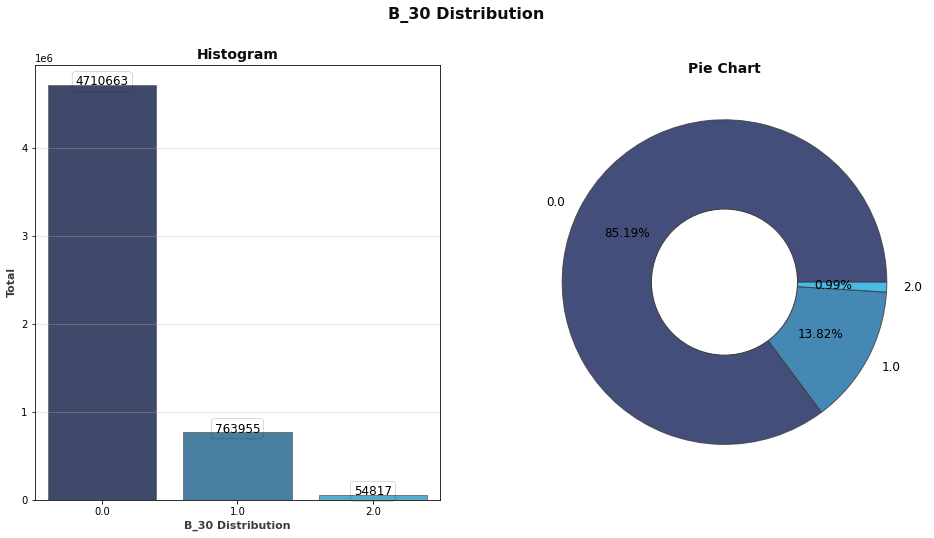

In [24]:
# --- Setting Colors, Labels, Order ---
black_grad = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']
cyan_grad = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#87EAFA']
colors=cyan_grad
labels=train_data['B_30'].dropna().unique()
order=train_data['B_30'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('B_30 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='B_30', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+100,rect.get_height(), horizontalalignment='center',
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))

plt.xlabel('B_30 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['B_30'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%',
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 29)
print('\033[1m'+'.: B_30 Content Total :.'+'\033[0m')
print('\033[36m*' * 29+'\033[0m')
train_data.B_38.value_counts(dropna=False)

*****************************
.: B_38 Content Total :.
*****************************


2.0    1953232
3.0    1255315
1.0    1160047
5.0     444856
4.0     294917
7.0     259028
6.0     162040
NaN       2016
Name: B_38, dtype: int64

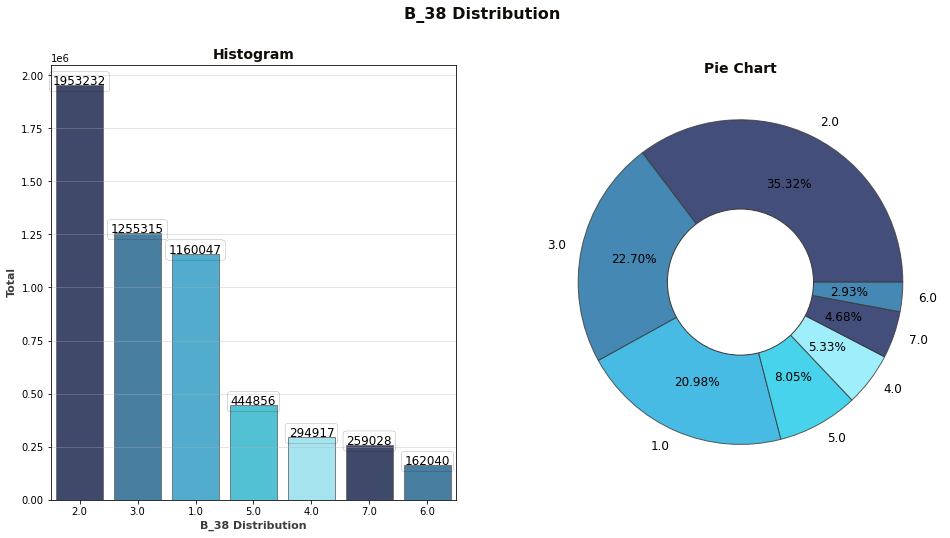

In [25]:
# --- Setting Colors, Labels, Order ---
black_grad = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']
cyan_grad = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#87EAFA']
colors=cyan_grad
labels=train_data['B_38'].dropna().unique()
order=train_data['B_38'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('B_38 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='B_38', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+100,rect.get_height(), horizontalalignment='center',
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))

plt.xlabel('B_38 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['B_38'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%',
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 29)
print('\033[1m'+'.: B_38 Content Total :.'+'\033[0m')
print('\033[36m*' * 29+'\033[0m')
train_data.B_38.value_counts(dropna=False)

In [26]:
def preprocessing(df, cat_features,num_features, i = 'train'):
    
    cid = pd.Categorical(df.pop('customer_ID'), ordered = True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
    penul = np.roll(last, -1)
    lt2 = (cid != np.roll(cid, -2))
    features = cat_features + num_features
    
    if 'target' in df.columns:
        df.drop(columns=['target'], inplace=True)
    gc.collect()
    print('Read', i)
        
    df_last = (df.loc[last,features]
              .rename(columns={f: f"{f}_lt" for f in features})
              .set_index(np.asarray(cid[last]))
             )
    gc.collect()
    print('Computed last', i)
    
    df_std = (df
              .groupby(cid)
              .std()[num_features]
              .rename(columns={f: f"{f}_std" for f in num_features})
            )
    gc.collect()
    print("computed std", i)

    df_avg = (df
              .groupby(cid)
              .mean()[num_features]
              .rename(columns={f: f"{f}_avg" for f in num_features})
            )
    gc.collect()
    print("computed avg", i)
        
    df = pd.concat([df_last,df_std, df_avg], axis=1)
    
    del df_last, df_std, df_avg,cid, last, penul, lt2, features
    
    return df

In [27]:
train = pd.read_parquet(f'../input/amex-data-integer-dtypes-parquet-format/train.parquet')

In [28]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
num_features = [col for col in train.columns if col not in cat_features + ["target", "customer_ID", "S_2"] ]

In [29]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    if isinstance(y_true, np.ndarray):
            y_true = pd.DataFrame(y_true, columns = ["target"])
    
    if isinstance(y_pred, np.ndarray):
            y_pred = pd.DataFrame(y_pred, columns = ["prediction"])
            #y_pred["prediction"] = y_pred
    
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
      
        df['weight'] = df["target"].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df["target"] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df["target"].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df["target"] * df['weight']).sum()
        df['cum_pos_found'] = (df["target"] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    d = top_four_percent_captured(y_true, y_pred)
    g = normalized_weighted_gini(y_true, y_pred)

    return 0.5 * (g + d)

In [30]:
def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [31]:
search_params = { 
    'learning_rate' : 0.065,
    'lambda_l1': 8.481514197781607,
    'lambda_l2': 0, #0.0004266339834880936,
    'num_leaves': 27,
    'feature_fraction': 0.484,
    'bagging_fraction': 0.8477112190030014,
    'bagging_freq': 2,
    'min_child_samples': 20
}

fixed_params={
    'objective': 'binary',
    'metric': 'custom', #'binay_logloss',
    'boosting_type' : 'gbdt',
    #'force_row_wise' : True,
    #'device': 'gpu',
    'random_state' : config.random_state,
    #'extra_trees' : True,
    #'feature_pre_filter': False,
    'n_estimators': 600,
    'early_stopping_round': 50
}

In [32]:
def train_modelo(df,target,features):
    
    x = df[features]
    y = pd.Series(target)
    
    #enc = OrdinalEncoder()
    #x[cat_features] = enc.fit_transform(x[cat_features])

    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,
                                random_state = config.random_state, stratify = y)
    
    model = LGBMClassifier(**fixed_params, **search_params)
    
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test,y_test)],
        eval_metric= lgb_amex_metric,
        callbacks=[log_evaluation(50)]
    )
    
    del x,y,X_train, y_train
    
    return model, X_test, y_test

In [33]:
features = [feat for feat in train.columns if feat != 'customer_ID' and feat != 'target' and feat != "S_2"]
len(features)


188

******************************
.: D_114 Total :.
******************************


1.0    3316478
0.0    2038257
NaN     176716
Name: D_114, dtype: int64

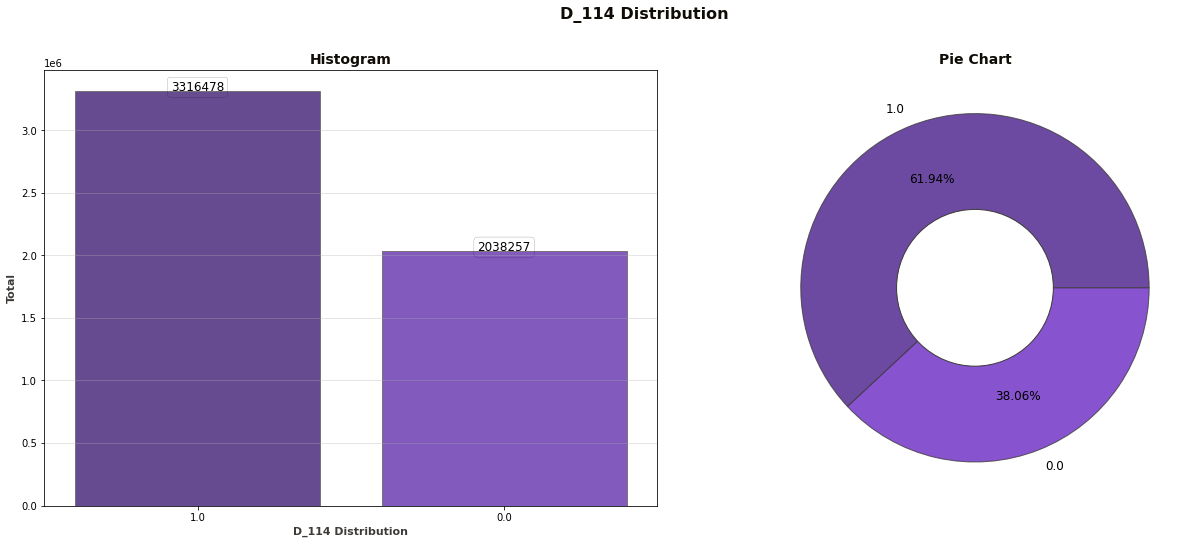

In [34]:
#Analyzing the Delinquency categorical variables
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_114'].dropna().unique()
order=train_data['D_114'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_114 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_114', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_114 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_114'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_114 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_114.value_counts(dropna=False)


******************************
.: D_116 Total :.
******************************


0.0    5348109
NaN     176716
1.0       6626
Name: D_116, dtype: int64

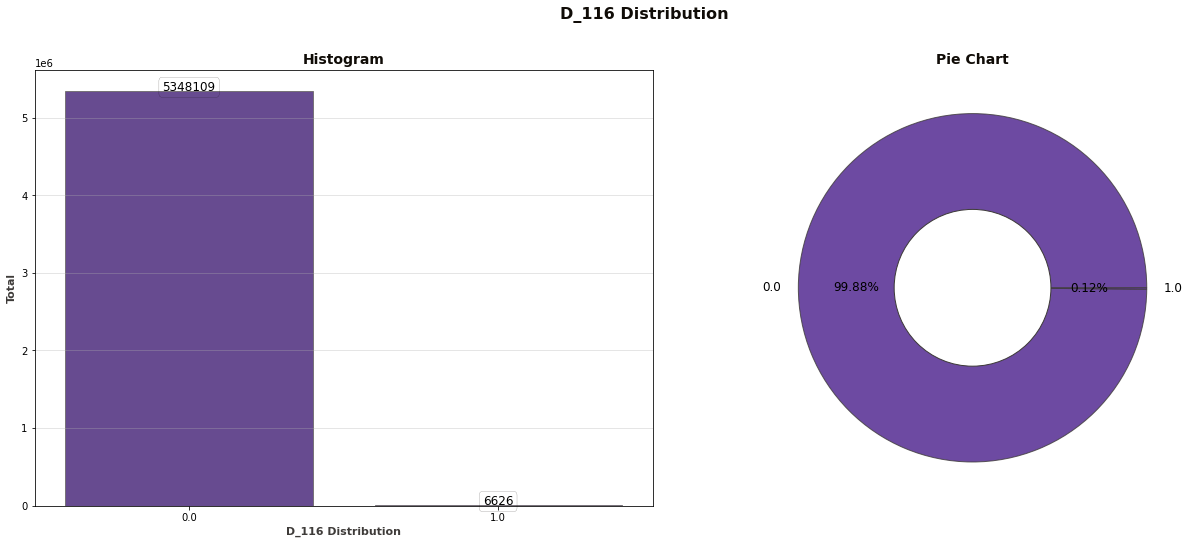

In [35]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_116'].dropna().unique()
order=train_data['D_116'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_116 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_116', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_116 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_116'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_116 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_116.value_counts(dropna=False)

******************************
.: D_117 Total :.
******************************


-1.0    1456084
3.0     1166400
4.0     1138666
2.0      666808
5.0      459290
6.0      344520
NaN      176716
1.0      122967
Name: D_117, dtype: int64

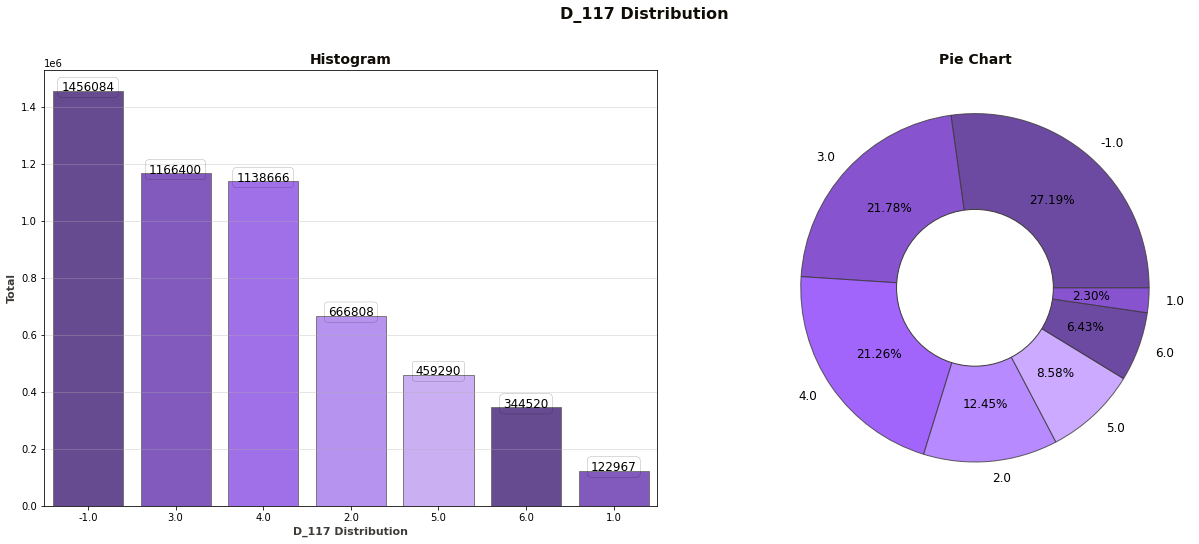

In [36]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_117'].dropna().unique()
order=train_data['D_117'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_117 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_117', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_117 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_117'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_117 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_117.value_counts(dropna=False)

******************************
.: D_120 Total :.
******************************


0.0    4729723
1.0     625012
NaN     176716
Name: D_120, dtype: int64

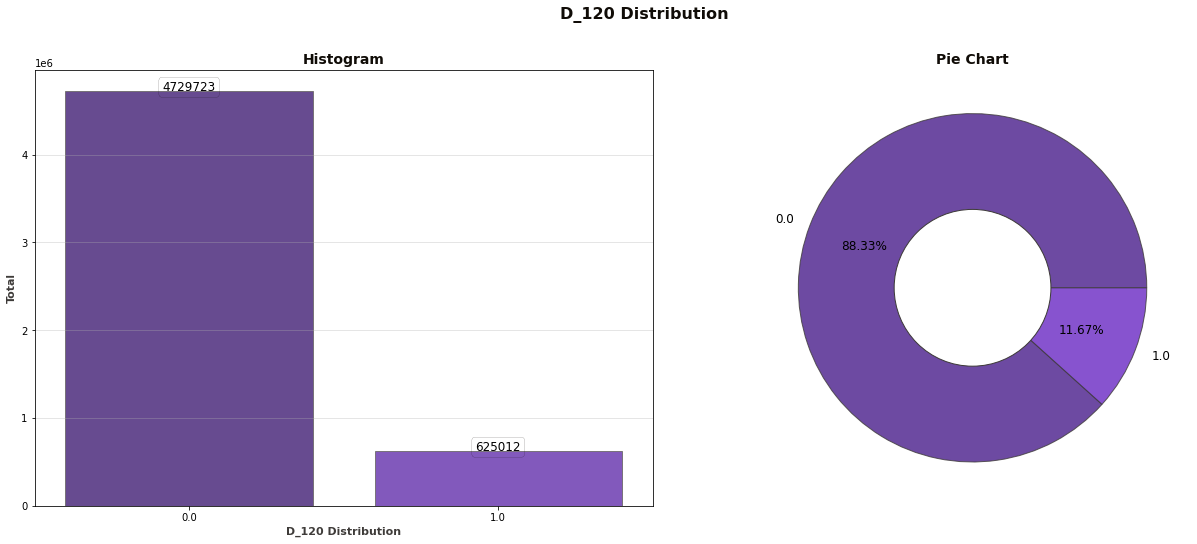

In [37]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_120'].dropna().unique()
order=train_data['D_120'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_120 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_120', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_120 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_120'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_120 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_120.value_counts(dropna=False)

******************************
.: D_63 Total :.
******************************


CO    4119621
CR     930133
CL     438390
XZ      25786
XM      10556
XL       6965
Name: D_63, dtype: int64

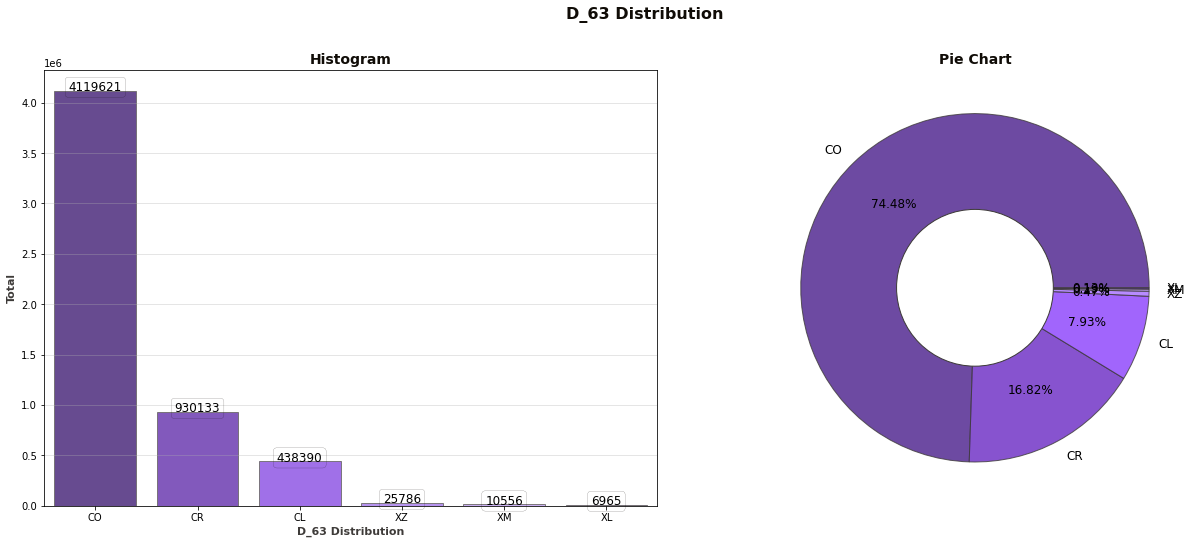

In [38]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_63'].dropna().unique()
order=train_data['D_63'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_63 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_63', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_63 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_63'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_63 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_63.value_counts(dropna=False)

******************************
.: D_64 Total :.
******************************


O     2913244
U     1523448
R      840112
       217442
-1      37205
Name: D_64, dtype: int64

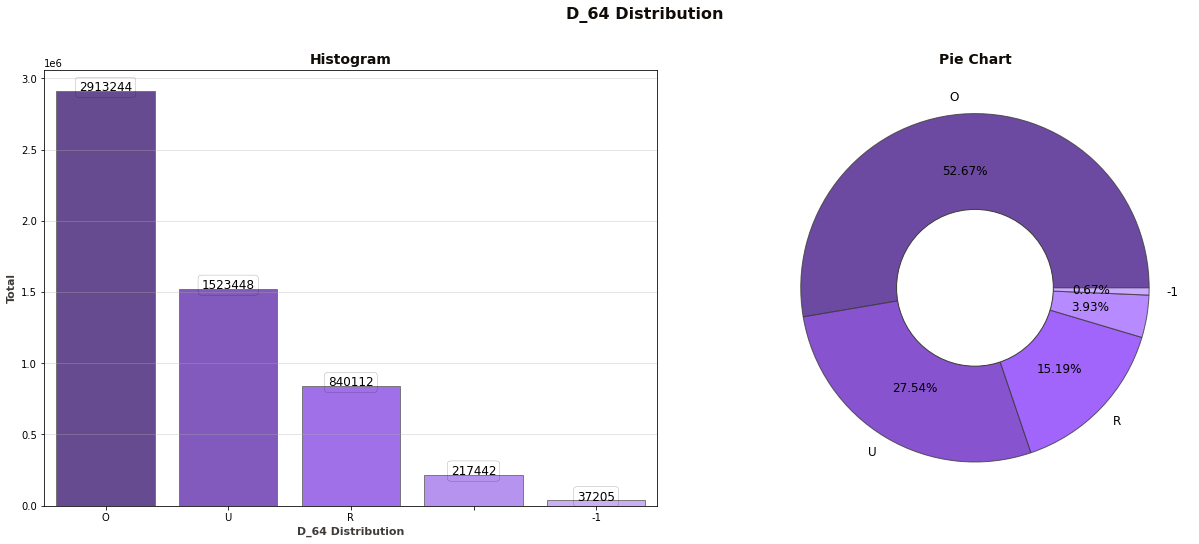

In [39]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_64'].dropna().unique()
order=train_data['D_64'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_64 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_64', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_64 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_64'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_64 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_64.value_counts(dropna=False)

******************************
.: D_66 Total :.
******************************


NaN    4908097
1.0     617066
0.0       6288
Name: D_66, dtype: int64

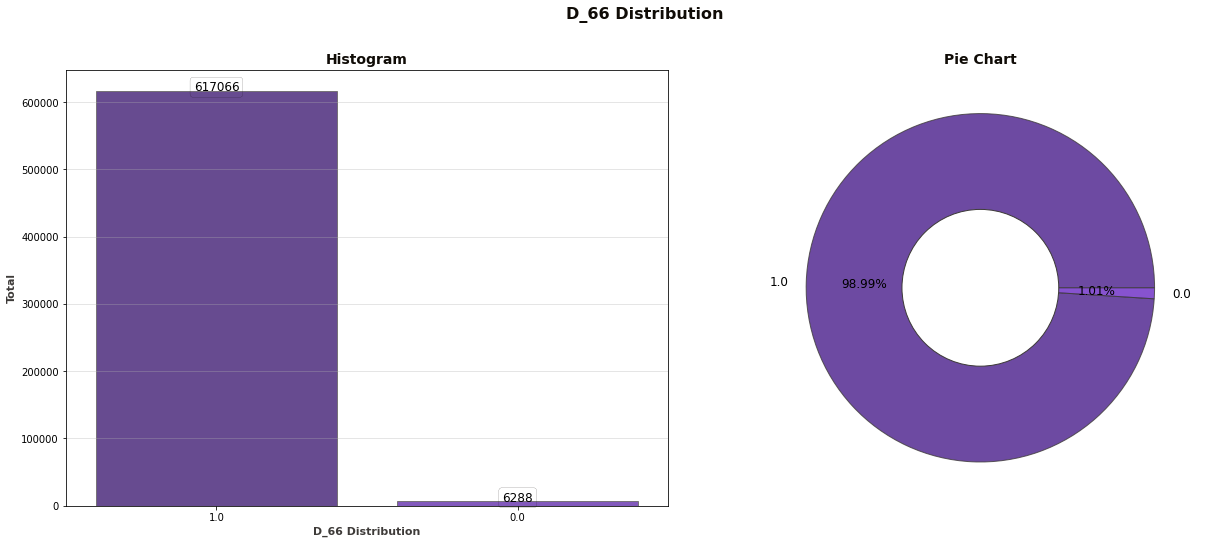

In [40]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_66'].dropna().unique()
order=train_data['D_66'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_66 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_66', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_66 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_66'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_66 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_66.value_counts(dropna=False)

******************************
.: D_68 Total :.
******************************


6.0    2782455
5.0    1201706
3.0     484442
4.0     477187
2.0     220111
NaN     216503
1.0     133122
0.0      15925
Name: D_68, dtype: int64

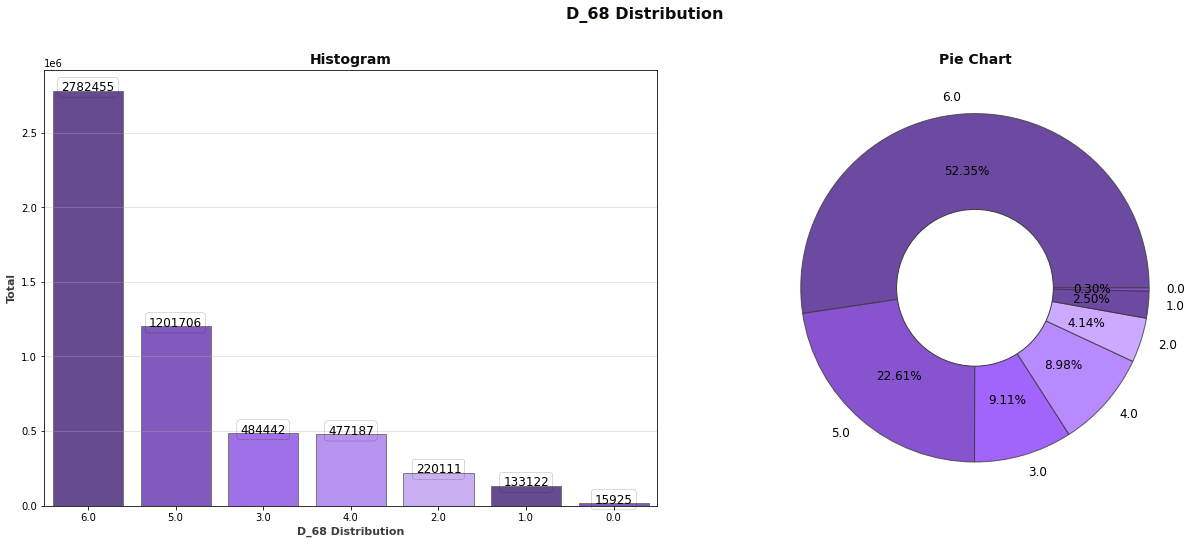

In [41]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_68'].dropna().unique()
order=train_data['D_68'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_68 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_68', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_68 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_68'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_68 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_68.value_counts(dropna=False)

******************************
.: D_126 Total :.
******************************


1.0     4262414
0.0      891323
-1.0     260898
NaN      116816
Name: D_126, dtype: int64

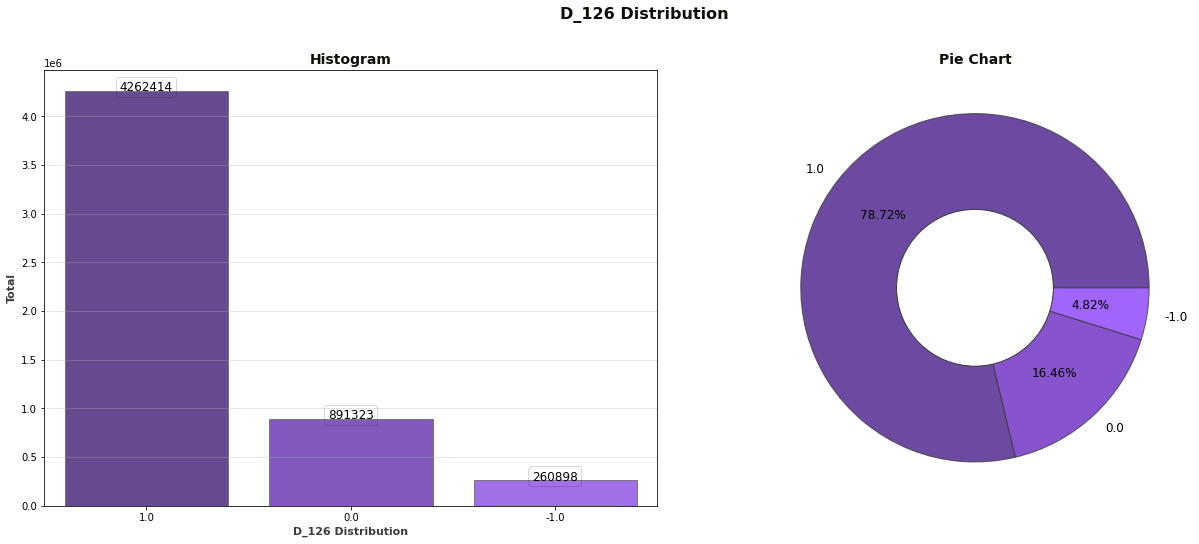

In [42]:
# --- Setting Colors, Labels, Order ---
purple_grad = ['#491D8B', '#6929C4', '#8A3FFC', '#A56EFF', '#BE95FF']
colors=purple_grad
labels=train_data['D_126'].dropna().unique()
order=train_data['D_126'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(18, 8))
plt.suptitle('D_126 Distribution', fontweight='heavy', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])

# --- Histogram ---
countplt = plt.subplot(1, 2, 1)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_126', data=train_data, palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, rect.get_height()+20,rect.get_height(), horizontalalignment='center', 
             fontsize=12, bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.15, boxstyle='round'))
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_126 Distribution', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Pie Chart ---
plt.subplot(1, 2, 2)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
plt.pie(train_data['D_126'].value_counts(), colors=colors, labels=order, pctdistance=0.67, autopct='%.2f%%', 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre);

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('\033[36m*' * 30)
print('\033[1m'+'.: D_126 Total :.'+'\033[0m')
print('\033[36m*' * 30+'\033[0m')
train_data.D_126.value_counts(dropna=False)

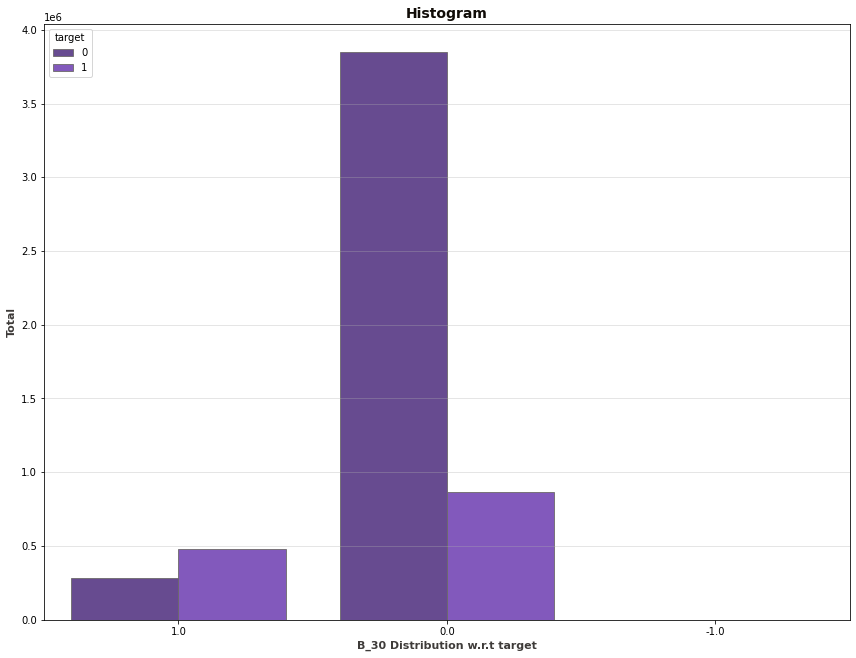

In [43]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='B_30', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('B_30 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

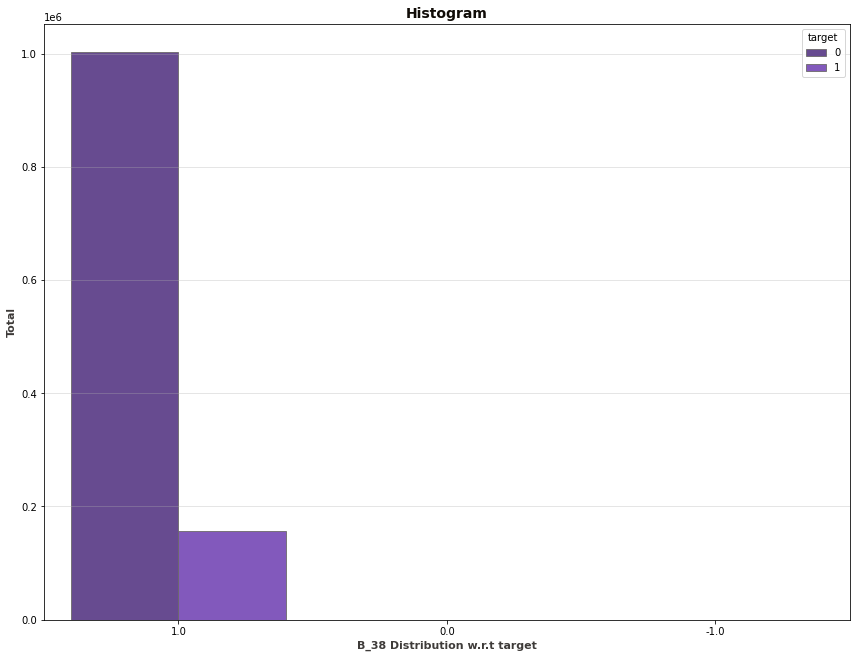

In [44]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='B_38', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('B_38 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

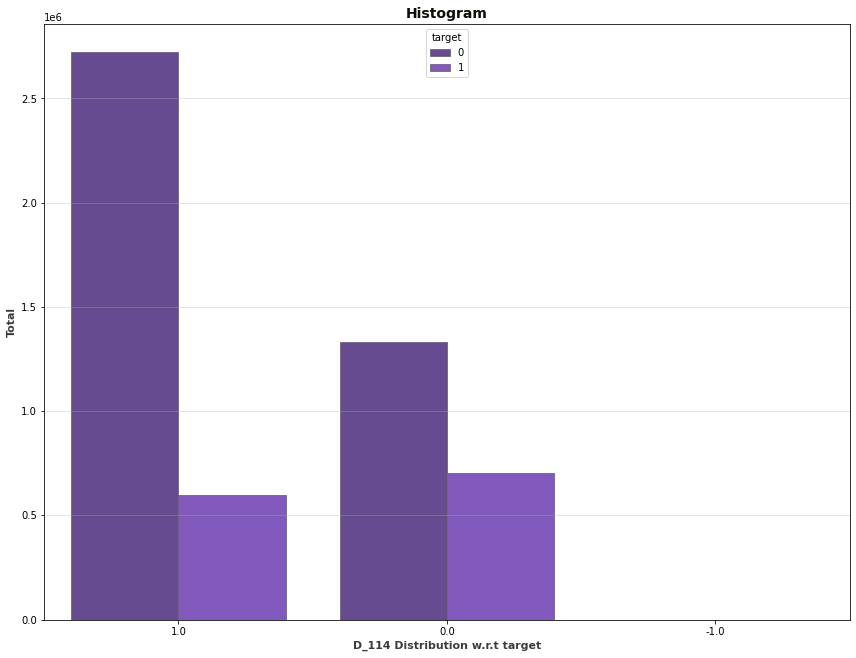

In [45]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_114', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_114 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

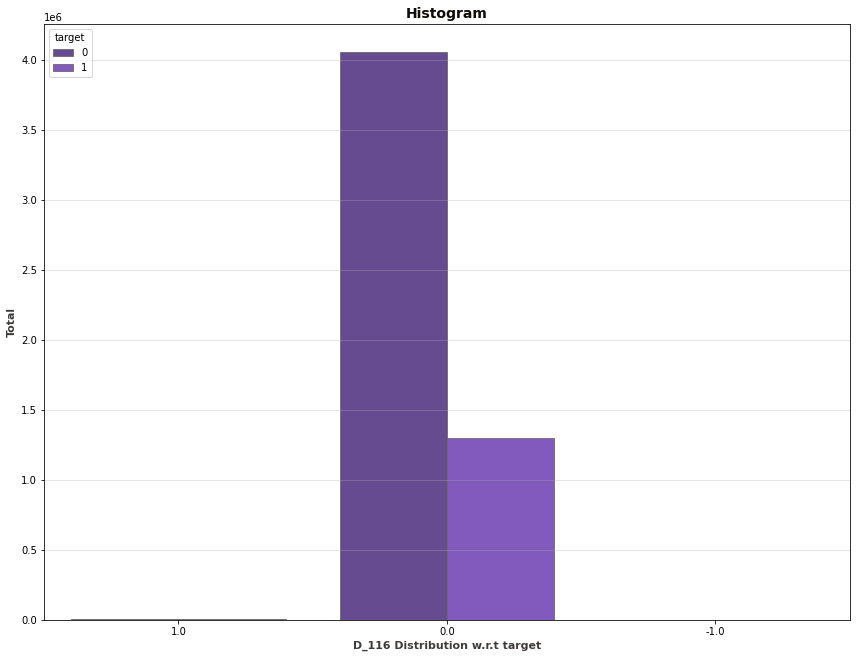

In [46]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_116', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_116 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

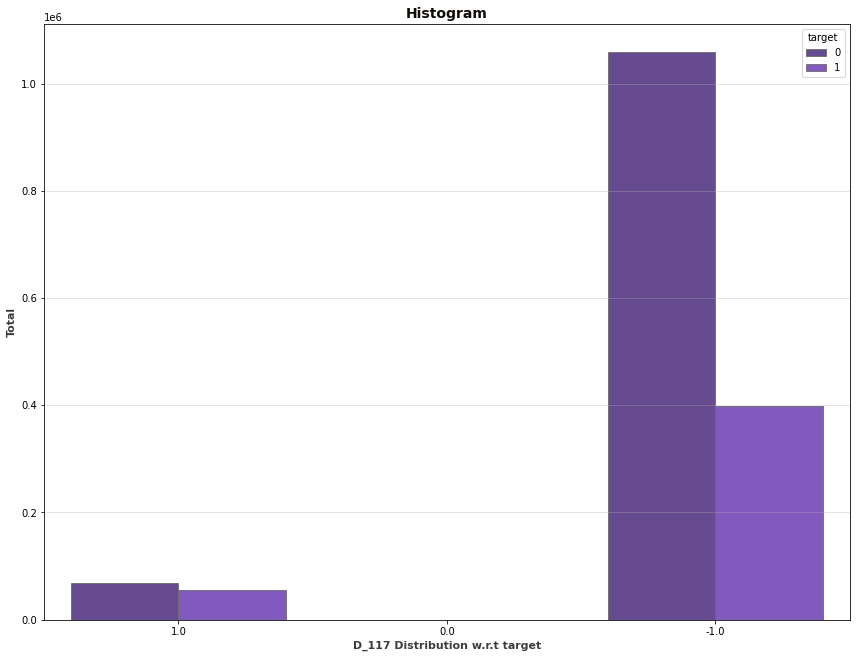

In [47]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_117', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_117 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

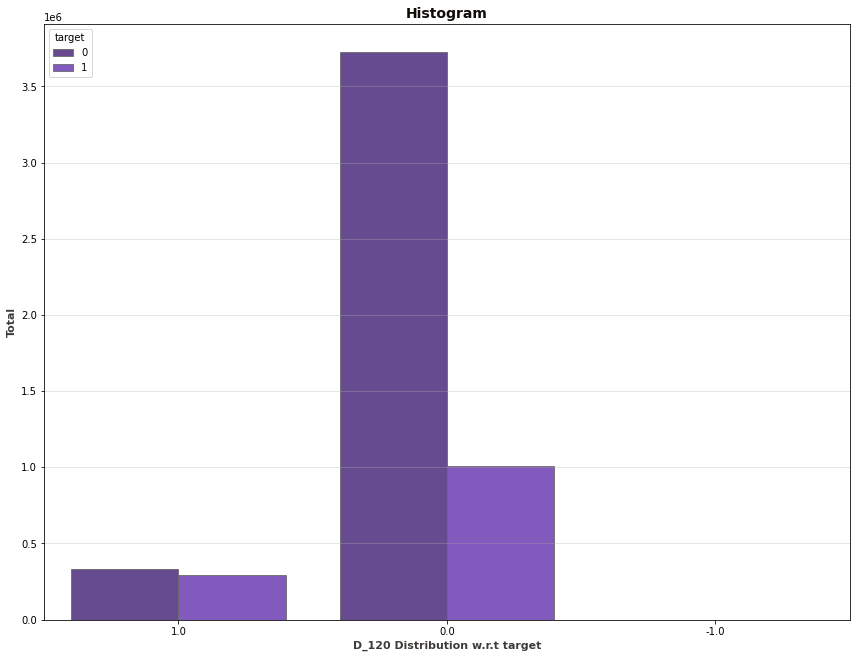

In [48]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_120', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_120 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

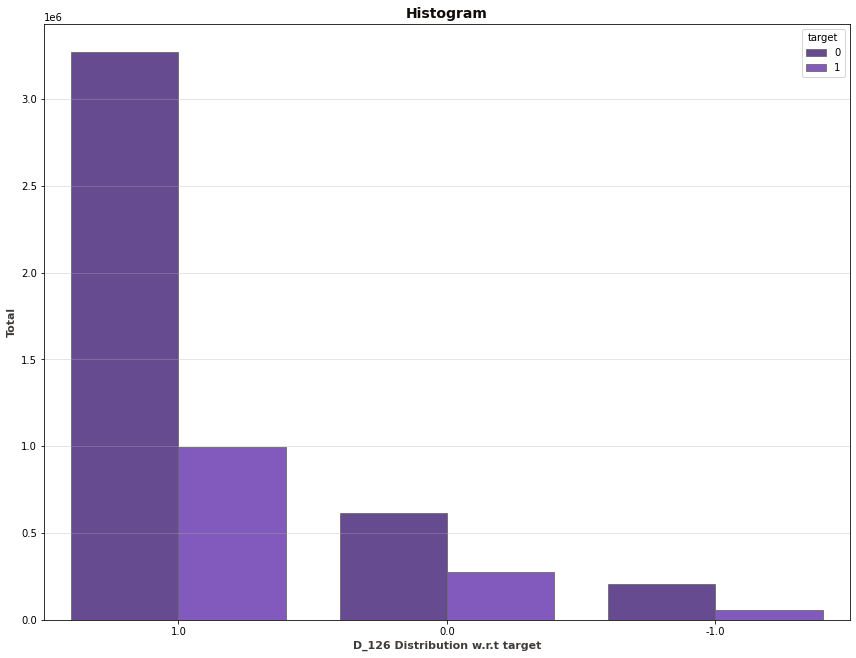

In [49]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_126', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_126 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

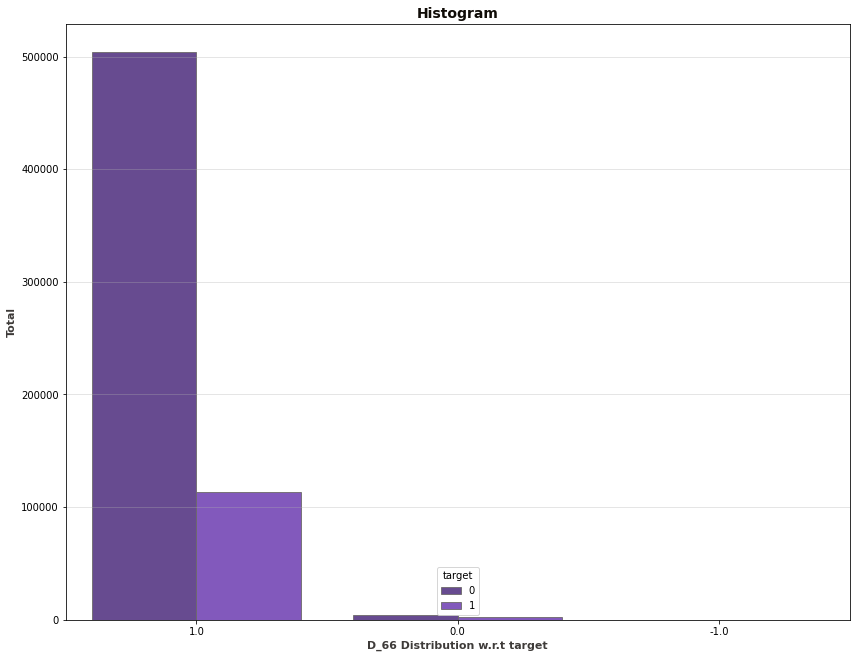

In [50]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_66', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_66 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

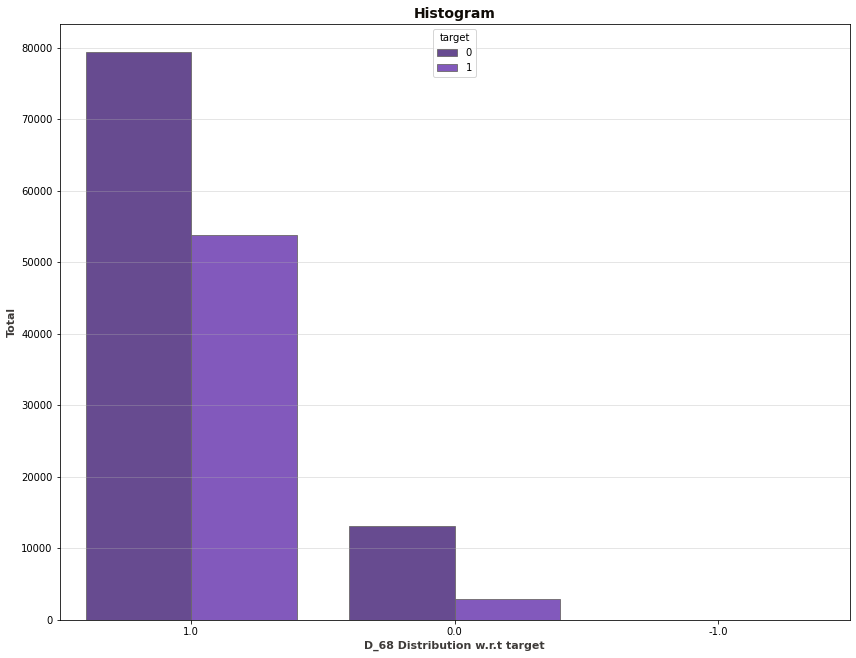

In [51]:
plt.figure(figsize=(12,10))
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='D_68', data=train_data,hue='target', palette=colors, order=order, edgecolor=black_grad[2], alpha=0.85)
plt.tight_layout(rect=[0, 0.04, 1, 0.965])
plt.xlabel('D_68 Distribution w.r.t target', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
plt.show()

In [52]:
categorical_cols=['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68',
          'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'target']

In [53]:
cols=[col for col in train_data.columns if (col.startswith(('B','T'))) & (col not in categorical_cols[:-1])]

train_balance_cols =train_data[cols]

In [54]:
train_balance_cols.select_dtypes(exclude='object').describe().T.style.background_gradient(cmap='RdPu').set_properties(**{'font-family': 'Segoe UI'})

,count,mean,std,min,25%,50%,75%,max
B_1,5531451.000000,nan,0.000000,-7.589844,0.008865,0.031342,0.125854,1.324219
B_2,5529435.000000,nan,0.000000,0.000000,0.105347,0.814453,1.001953,1.009766
B_3,5529435.000000,nan,0.000000,0.000000,0.005226,0.009781,0.155029,1.625000
B_4,5531451.000000,nan,0.000000,0.000000,0.027496,0.082214,0.238892,19.796875
B_5,5531451.000000,nan,0.000000,0.000000,0.007282,0.015373,0.053711,144.250000
B_6,5531218.000000,nan,nan,-0.005177,0.020493,0.083374,0.191895,1215.000000
B_7,5531451.000000,nan,0.000000,-2.652344,0.028244,0.075745,0.270996,1.252930
B_8,5509183.000000,nan,0.000000,0.000000,0.004505,0.009018,1.003906,1.019531
B_9,5531451.000000,nan,0.000000,0.000000,0.005753,0.025879,0.334229,27.421875
B_10,5531451.000000,nan,nan,-0.002958,0.028992,0.110535,0.295654,4096.000000


*******************************************
.: Total Missing Values in each Columns :.
*******************************************


B_1           0
B_2        2016
B_3        2016
B_4           0
B_5           0
B_6         233
B_7           0
B_8       22268
B_9           0
B_10          0
B_11          0
B_12          0
B_13      49519
B_14          0
B_15       6923
B_16       2016
B_17    3137598
B_18          0
B_19       2016
B_20       2016
B_21          0
B_22       2016
B_23          0
B_24          0
B_25       6923
B_26       2016
B_27       2016
B_28          0
B_29    5150035
B_31          0
B_32          0
B_33       2016
B_36          0
B_37         56
B_39    5497819
B_40         53
B_41        690
B_42    5459973
dtype: int64

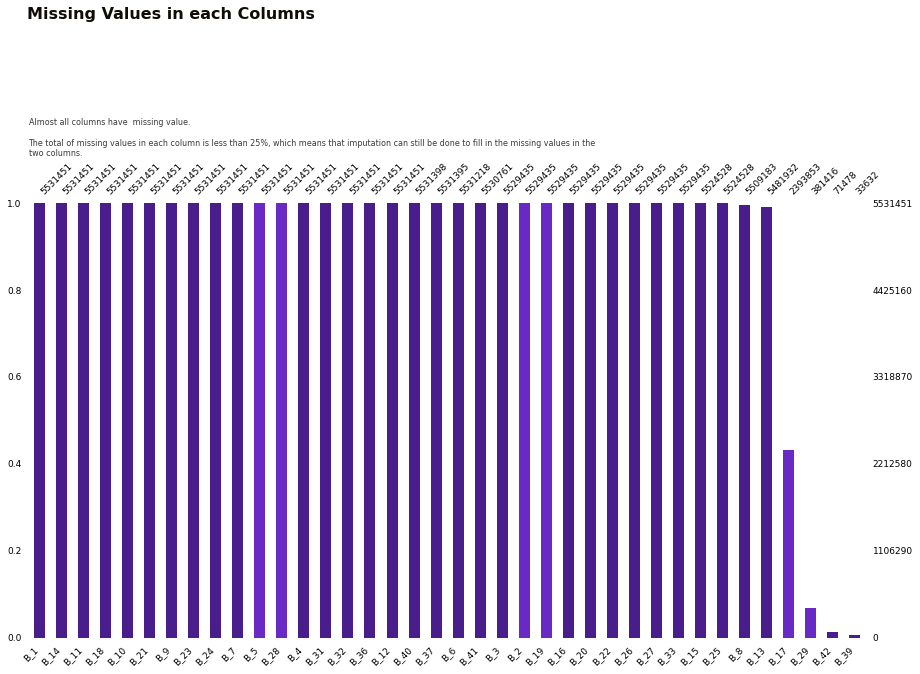

In [55]:
# --- Plot Missing Values ---
mso.bar(train_balance_cols, fontsize=9, color=[purple_grad[0], purple_grad[0], purple_grad[0], purple_grad[0], purple_grad[0], purple_grad[0],
                               purple_grad[0], purple_grad[0], purple_grad[0], purple_grad[0], purple_grad[1], purple_grad[1]], 
        figsize=(15, 8), sort='descending', labels=True)

# --- Title & Subtitle Settings ---
plt.suptitle('Missing Values in each Columns', fontweight='heavy', x=0.124, y=1.22, ha='left',fontsize='16', 
             fontfamily='sans-serif', color=black_grad[0])
plt.title('Almost all columns have  missing value.\n\nThe total of missing values in each column is less than 25%, which means that imputation can still be done to fill in the missing values in the\ntwo columns.', 
          fontsize='8', fontfamily='sans-serif', loc='left', color=black_grad[1], pad=5)
plt.grid(axis='both', alpha=0);

# --- Total Missing Values in each Columns ---
print('\033[36m*' * 43)
print('\033[1m'+'.: Total Missing Values in each Columns :.'+'\033[0m')
print('\033[36m*' * 43+'\033[0m')
train_balance_cols.isnull().sum()

In [56]:
train_balance_cols.columns

Index(['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_39', 'B_40', 'B_41', 'B_42'], dtype='object')

In [57]:
import os
import pandas as pd

df_1 = pd.read_csv('../input/amex-all-feats-preds/test_lgbm_v3_5fold_seed42.csv')
df_1.to_csv('submission.csv', index=False)